# Análise do Data Warehouse

Análise dos dados disponibilizados no Data Warehouse



**Instalando o Cassandra no Jupyter**

`docker-compose exec jupyter pip install cassandra-driver`

## Imports

In [1]:
#Imports
from time import sleep

In [2]:
#Imports Cassandra
from cassandra.auth import PlainTextAuthProvider
from cassandra.cluster import Cluster

In [3]:
#Imports Pandas
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

## Conexão ao banco de Dados Cassandra

In [4]:
#Conectando a seção
ap = PlainTextAuthProvider(username='cassandra', password='cassandra')
cluster = Cluster(['cassandra'], protocol_version=4, auth_provider=ap)
session = cluster.connect('alunos')
session.default_timeout = 60
session.row_factory = pandas_factory
sleep(2)

## Consulta

### Configurando a consulta
Atribuindo valores para as consultas

In [5]:
table = 'fato_aluno_cor'
field = 'cor_raca'
curse_types = ['Técnico']
filters = {    
    'categoria_situacao': ['Evadidos','Concluintes'],
    field: True,
    'tipo_curso': len(curse_types) > 0,
    'instituicao': 'IFPB',
    'unidade_ensino': '',
    'nome_curso': '',
    
}

### Construindo a string para a consulta
Criando fields e grupos para a consulta

In [6]:
s = []
gf = []
for k, v in filters.items():
    if v :
        if type(v) is str:
            s.append("({} = '{}')".format(k,v))            
        elif type(v) is list:
            s.append("({} IN ({}))".format(
                k,','.join(map(str,["'{}'".format(i) for i in v]))))
        if (type(v) is bool and v) or (not type(v) is bool):
            gf.append(k)
filter_sql = " AND ".join(map(str,s))
fields = ", ".join(map(str,gf))


### Execultado a consulta

In [7]:
#Execultado Consulta
sql = "SELECT {0}, sum(quant_grupo) AS quant_grupo" \
" FROM {1} " \
" WHERE {2} " \
" GROUP BY {0}" \
" ALLOW FILTERING;".format(
    fields,
    table,
    filter_sql)
rslt = session.execute(sql, timeout=None)
original_df = rslt._current_rows
original_df


,categoria_situacao,cor_raca,tipo_curso,instituicao,quant_grupo
0,Concluintes,Amarela,Bacharelado,IFPB,3
1,Concluintes,Amarela,Licenciatura,IFPB,3
2,Concluintes,Amarela,Qualificação Profissional (FIC),IFPB,15
3,Concluintes,Amarela,Tecnologia,IFPB,13
4,Concluintes,Amarela,Técnico,IFPB,44
...,...,...,...,...,...
68,Evadidos,Preta,Especialização (Lato Sensu),IFPB,4
69,Evadidos,Preta,Licenciatura,IFPB,68
70,Evadidos,Preta,Qualificação Profissional (FIC),IFPB,42
71,Evadidos,Preta,Tecnologia,IFPB,119


## Análise

In [8]:
s = original_df.shape
print("Número de registros {:,} e número de colunas {:,}.".format(s[0], s[1]).replace(',','.'))

Número de registros 73 e número de colunas 5.


## Filtrando Tipo do Curso

In [9]:
if curse_types :
    original_df = original_df[original_df['tipo_curso'].isin(curse_types)]
    print('Fitrando pelos tipos de cursos:\n {}'.format(', '.join(map(str,curse_types))))
    
else:
    print('Todos os cursos')
original_df

Fitrando pelos tipos de cursos:
 Técnico


,categoria_situacao,cor_raca,tipo_curso,instituicao,quant_grupo
4,Concluintes,Amarela,Técnico,IFPB,44
11,Concluintes,Branca,Técnico,IFPB,1094
14,Concluintes,Indígena,Técnico,IFPB,15
21,Concluintes,Não Declarada,Técnico,IFPB,574
28,Concluintes,Parda,Técnico,IFPB,1579
34,Concluintes,Preta,Técnico,IFPB,215
40,Evadidos,Amarela,Técnico,IFPB,52
48,Evadidos,Branca,Técnico,IFPB,1180
51,Evadidos,Indígena,Técnico,IFPB,15
58,Evadidos,Não Declarada,Técnico,IFPB,425


## Agrupando

### Agrupando os valores para apresentar no gráfico

In [10]:
df = original_df.groupby(['categoria_situacao',field]).sum('quant_grupo').reset_index()
df_qtd = original_df.groupby([field]).sum('quant_grupo').reset_index()
order = list(df_qtd.sort_values('quant_grupo', ascending=False)[field])

### Ordenação personalizada

In [11]:
#order = []

### Ordenando dados

In [12]:
sort_keys = {v:k for k,v in enumerate(order)}
func_sort = lambda e: sort_keys[e]
df_cat = df.pivot_table('quant_grupo',[field],'categoria_situacao').sort_values(by=field, key=lambda col: col.map(func_sort))
df_qtd = df_qtd.pivot_table('quant_grupo',[field]).sort_values(by=field, key=lambda col: col.map(func_sort))

### Apresentando o gráfico

<AxesSubplot:xlabel='cor_raca'>

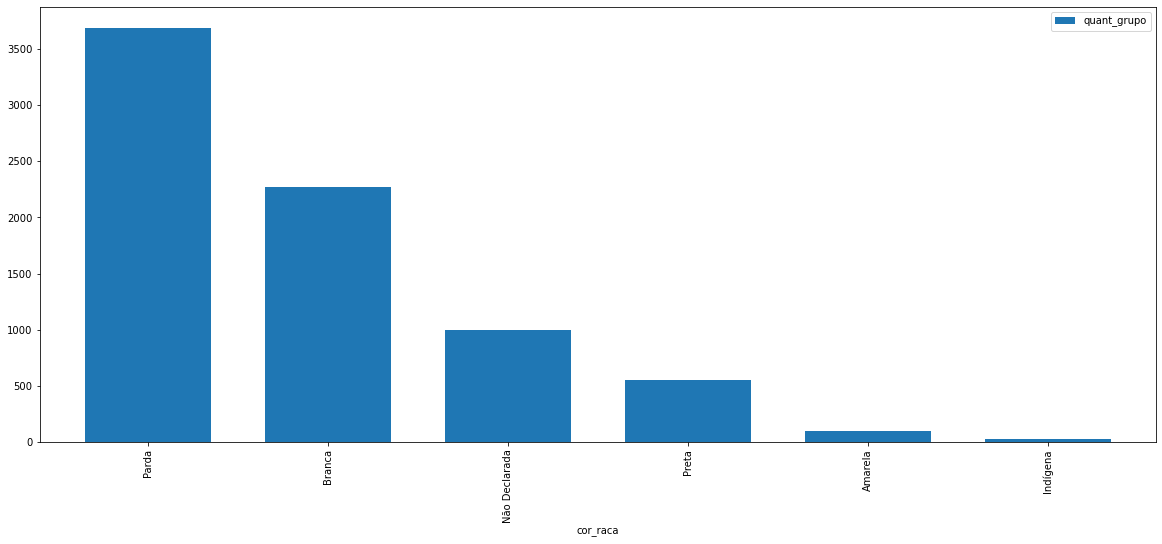

In [13]:
df_qtd.plot(kind ='bar', figsize=(20, 8), width = 0.7)

<AxesSubplot:xlabel='cor_raca'>

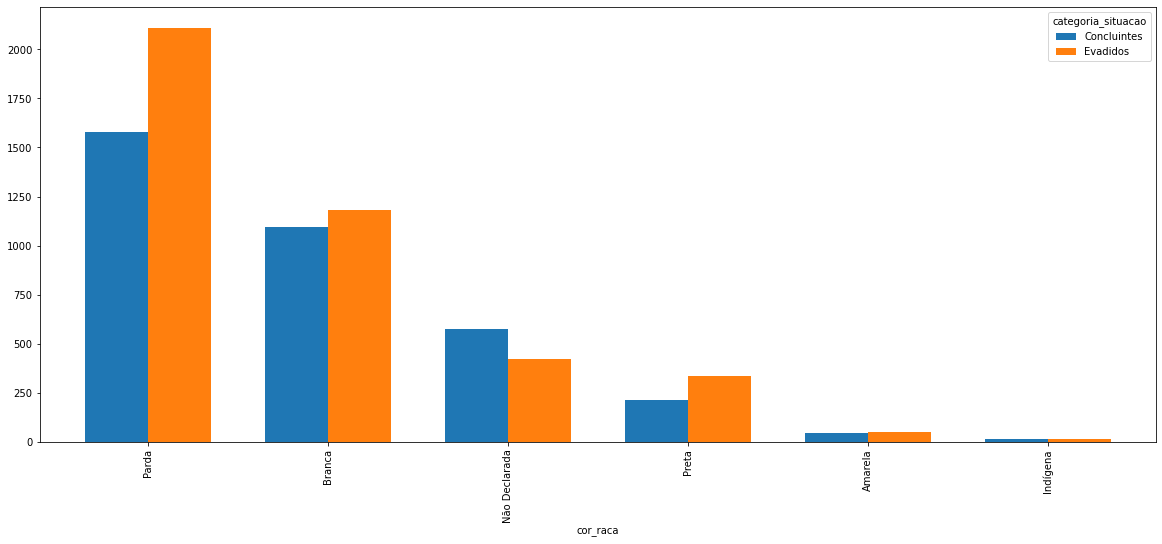

In [14]:
df_cat.plot(kind ='bar', figsize=(20, 8), width = 0.7)

## Total de Alunos

In [15]:
categories = list(df['categoria_situacao'].unique())
total = df['quant_grupo'].sum()
df_res = df_cat 
df_res['total'] = df_res[categories].sum(axis=1)
for category in categories:
    df_res[category + '_%'] = df_res[category] / df_res['total']
df_res['total_%'] = df_res['total'] / total
df_res

categoria_situacao,Concluintes,Evadidos,total,Concluintes_%,Evadidos_%,total_%
cor_raca,,,,,,
Parda,1579,2110,3689,0.428029,0.571971,0.482980
Branca,1094,1180,2274,0.481091,0.518909,0.297722
Não Declarada,574,425,999,0.574575,0.425425,0.130793
Preta,215,335,550,0.390909,0.609091,0.072008
Amarela,44,52,96,0.458333,0.541667,0.012569
Indígena,15,15,30,0.500000,0.500000,0.003928


In [16]:
print("Total de alunos: {:,}".format(df['quant_grupo'].sum()).replace(',','.'))

Total de alunos: 7.638


# Porcentagem de Conclusão

<AxesSubplot:xlabel='cor_raca'>

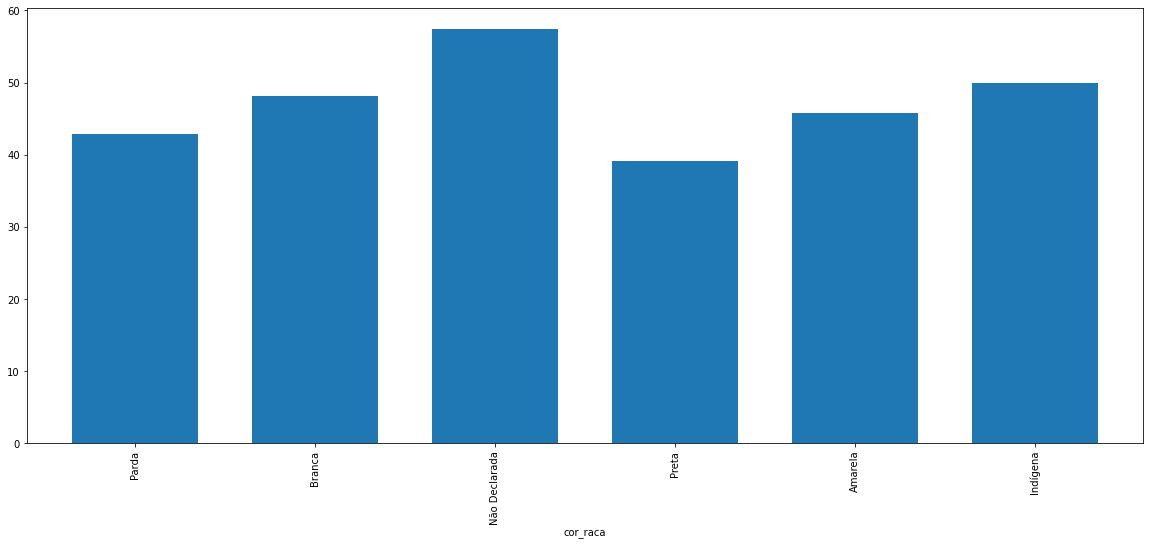

In [17]:
df_drp = df_res['Concluintes_%'] * 100

df_drp.plot(kind ='bar', figsize=(20, 8), width = 0.7)